In [19]:

import tushare as ts
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler


In [20]:
df=pd.read_csv('R.csv')
df.head()

,BJFS,BJYQ,HEYY,HELQ,HEZJ
0,0.01502,-0.01460,-0.02463,-0.02155,-0.00602
1,0.00656,-0.01830,-0.03097,-0.02718,-0.01652
2,0.01247,-0.01197,-0.02190,-0.01968,-0.00888
3,0.01429,-0.00682,-0.02017,-0.01842,-0.00642
4,0.01597,-0.00698,-0.01949,-0.01651,-0.00565


In [21]:

def split_windows(data, size):
    X = []
    Y = []
    for i in range(len(data) - size):
        X.append(data[i:i+size, :])
        Y.append(data[i+size, 2])
    return np.array(X), np.array(Y)


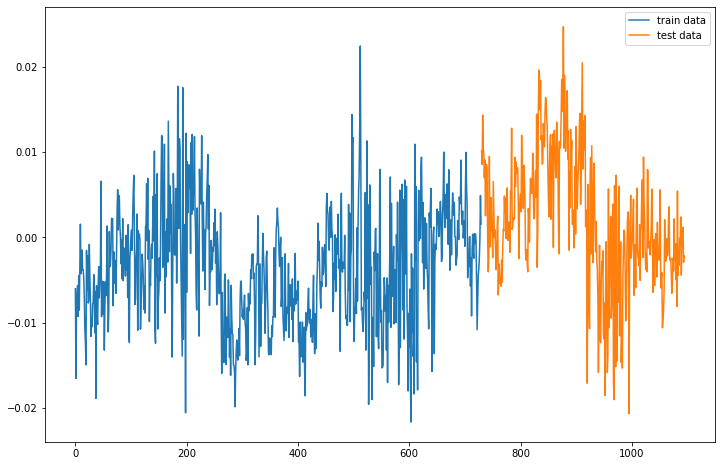

In [22]:
all_data = df.values
train_len = 730
train_data = all_data[:train_len, :]
test_data = all_data[train_len:, :]
 
 
plt.figure(figsize=(12, 8))
plt.plot(np.arange(train_data.shape[0]), train_data[:, 4], label='train data')
plt.plot(np.arange(train_data.shape[0], train_data.shape[0] + test_data.shape[0]), test_data[:, 4], label='test data')
plt.legend()


In [23]:
# normalizatioin processing
scaler = MinMaxScaler()
scaled_train_data = scaler.fit_transform(train_data)
scaled_test_data = scaler.transform(test_data)

window_size = 10
train_X, train_Y = split_windows(scaled_train_data, size=window_size)
test_X, test_Y = split_windows(scaled_test_data, size=window_size)
print('train shape', train_X.shape, train_Y.shape)
print('test shape', test_X.shape, test_Y.shape)


train shape (720, 10, 5) (720,)
test shape (355, 10, 5) (355,)


In [24]:

window_size = 10
fea_num = 5
 
 
model = keras.models.Sequential([
    keras.layers.Input((window_size, fea_num)),
    keras.layers.Reshape((window_size, fea_num, 1)),
    keras.layers.Conv2D(filters=64,
                           kernel_size=3,
                           strides=1,
                           padding="same",
                           activation="relu"),
    keras.layers.MaxPooling2D(pool_size=2, strides=1, padding="same"),
    keras.layers.Dropout(0.3),
    keras.layers.Reshape((window_size, -1)),
    keras.layers.LSTM(128, return_sequences=True),
    keras.layers.LSTM(64, return_sequences=False),
    keras.layers.Dense(32, activation="relu"),
    keras.layers.Dense(1)
])
 
 
model.compile(loss='mse', optimizer='adam', metrics=['mse'])
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 10, 5, 1)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 5, 64)         640       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 5, 64)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 5, 64)         0         
_________________________________________________________________
reshape_3 (Reshape)          (None, 10, 320)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 10, 128)           229888    
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)               

In [25]:
model.fit(x=train_X, y=train_Y, epochs=50)

Epoch 1/50
23/23 [==============================] - 0s 16ms/step - loss: 0.0512 - mse: 0.0512
Epoch 2/50
23/23 [==============================] - 0s 14ms/step - loss: 0.0202 - mse: 0.0202
Epoch 3/50
23/23 [==============================] - 0s 14ms/step - loss: 0.0192 - mse: 0.0192
Epoch 4/50
23/23 [==============================] - 0s 14ms/step - loss: 0.0188 - mse: 0.0188
Epoch 5/50
23/23 [==============================] - 0s 14ms/step - loss: 0.0189 - mse: 0.0189
Epoch 6/50
23/23 [==============================] - 0s 14ms/step - loss: 0.0183 - mse: 0.0183
Epoch 7/50
23/23 [==============================] - 0s 14ms/step - loss: 0.0188 - mse: 0.0188
Epoch 8/50
23/23 [==============================] - 0s 14ms/step - loss: 0.0188 - mse: 0.0188
Epoch 9/50
23/23 [==============================] - 0s 15ms/step - loss: 0.0193 - mse: 0.0193
Epoch 10/50
23/23 [==============================] - 0s 15ms/step - loss: 0.0176 - mse: 0.0176
Epoch 11/50
23/23 [==============================] - 0s 15m

RMSE 0.007162139559239995


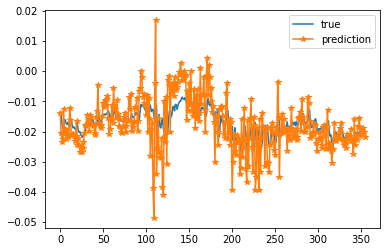

In [28]:

prediction = model.predict(test_X)
scaled_prediction = prediction * (scaler.data_max_[2] - scaler.data_min_[2]) + scaler.data_min_[2]
scaled_true = test_Y * (scaler.data_max_[2] - scaler.data_min_[2]) + scaler.data_min_[2]
plt.plot(range(len(scaled_prediction)), scaled_prediction, label='true')
plt.plot(range(len(scaled_true)), scaled_true, label='prediction', marker='*')
plt.legend()
 
 

from sklearn.metrics import mean_squared_error
print('RMSE', np.sqrt(mean_squared_error(scaled_prediction, scaled_true)))


In [17]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
print('MAE', np.sqrt(mean_absolute_error(scaled_prediction, scaled_true)))

MAE 0.06997340077861194


In [27]:
data = pd.DataFrame(scaled_prediction)
data.to_csv('output.csv')

In [29]:
b = pd.DataFrame(scaled_true)
b.to_csv('or.csv')